# Ground-to-sky viewfactor

This post shows two things:

- How to calculate, in an infinite sheds model, the view factor to the sky from a point underneath the array
- How to create, using matplotlib, an HTML animation that works with sphinx and nbviewer.org

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from pvlib.tools import cosd, sind, tand

In [2]:
def calc_vf(x, rotation, collector_width, pitch, height, N=50):
    """
    Calculate the fraction of the sky dome visible from a point on the ground,
    accounting for partial obstruction by infinite sheds.

    Parameters
    ----------
    x : float
        Position between rows (along the horizontal axis perpendicular to the sheds) [m]
    rotation : float
        Rotation (positive or negative surface_tilt) of the sheds [degrees]
    collector_width : float
        Slant length of sheds [m]
    pitch : float
        On-center row spacing [m]
    height : float
        Height of center of modules [m]
    N : int, default 50
        Number of sheds to consider in the forwards and backwards directions.
        50 is way overkill for a reasonable array.

    Returns
    -------
    vf : float
        Fraction of sky dome visible from the specified ground point [unitless]
    wedge_angles : list of (float, float)
        Bounding angles of each wedge of visible sky [degrees]
    """
    all_k = np.arange(-N, N)
    phi_k_1 = np.degrees(np.arctan2(height - collector_width * sind(rotation) / 2, all_k*pitch + collector_width * cosd(rotation)/2 - x))
    phi_k_2 = np.degrees(np.arctan2(height + collector_width * sind(rotation) / 2, all_k*pitch - collector_width * cosd(rotation)/2 - x))
    phi_k_max = np.maximum(phi_k_1, phi_k_2)
    phi_k_min = np.minimum(phi_k_1, phi_k_2)
    wedge_vfs = 0.5*(cosd(phi_k_max[1:]) - cosd(phi_k_min[:-1]))
    keep = wedge_vfs > 0
    st = phi_k_max[1:][keep]
    ed = phi_k_min[:-1][keep]
    vf = np.sum(np.where(wedge_vfs>0, wedge_vfs, 0))
    return vf, list(zip(st, ed))

In [3]:
def calc_phi(x, xm, zm):
    return np.degrees(np.arctan2(zm, xm-x))

def plot_wedge(x, phi1, phi2, **kwargs):
    dx = 100
    sign1 = 1 if abs(phi1) < 90 else -1
    sign2 = 1 if abs(phi2) < 90 else -1
    t1 = np.array([x, 0]) + sign1 * np.array([dx, tand(phi1) * dx])
    t2 = np.array([x, 0]) + sign2 * np.array([dx, tand(phi2) * dx])
    plt.fill([x, t1[0], t2[0]], [0, t1[1], t2[1]], **kwargs)
    
def plot_scene(x, rotation, collector_width, pitch, height, fig):
    plt.gca().clear()
    # draw modules and sky wedges
    for k in k_range:
        # plot modules:
        delta = collector_width * np.array([cosd(rotation), -sind(rotation)])
        pos_center = np.array([k * pitch, height])
        pos_left = pos_center - delta/2
        pos_right = pos_left + delta
        plt.plot([pos_left[0], pos_right[0]], [pos_left[1], pos_right[1]], c='k', marker='o', markerfacecolor='r', ms=3)

        # plot shaded sky wedges:
        phi_left = calc_phi(x, pos_left[0], pos_left[1])
        phi_right = calc_phi(x, pos_right[0], pos_right[1])
        plot_wedge(x, phi_left, phi_right, c='grey', alpha=0.5)

        # plot module ID (k):
        plt.text(pos_left[0], -1, f'k={k}'.replace('-', '−'))

    # plot unshaded wedges:
    _, wedge_angles = calc_vf(x, rotation, collector_width, pitch, height)
    for phi1, phi2 in wedge_angles:
        plot_wedge(x, phi1, phi2, c='yellow', alpha=0.5, ls='')

    # plot ground:
    plt.plot([k_range[0]*pitch, k_range[-1]*pitch], [0, 0], c='k')
    plt.scatter([x], [0], marker='x', c='r')

    # display plot:
    plt.xlim((k_range[0]-1)*pitch, (k_range[-1]+1)*pitch)
    plt.ylim(-height/4, 1.2*height)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.gca().set_title(f'Number of visible sky wedges: {len(wedge_angles)}')


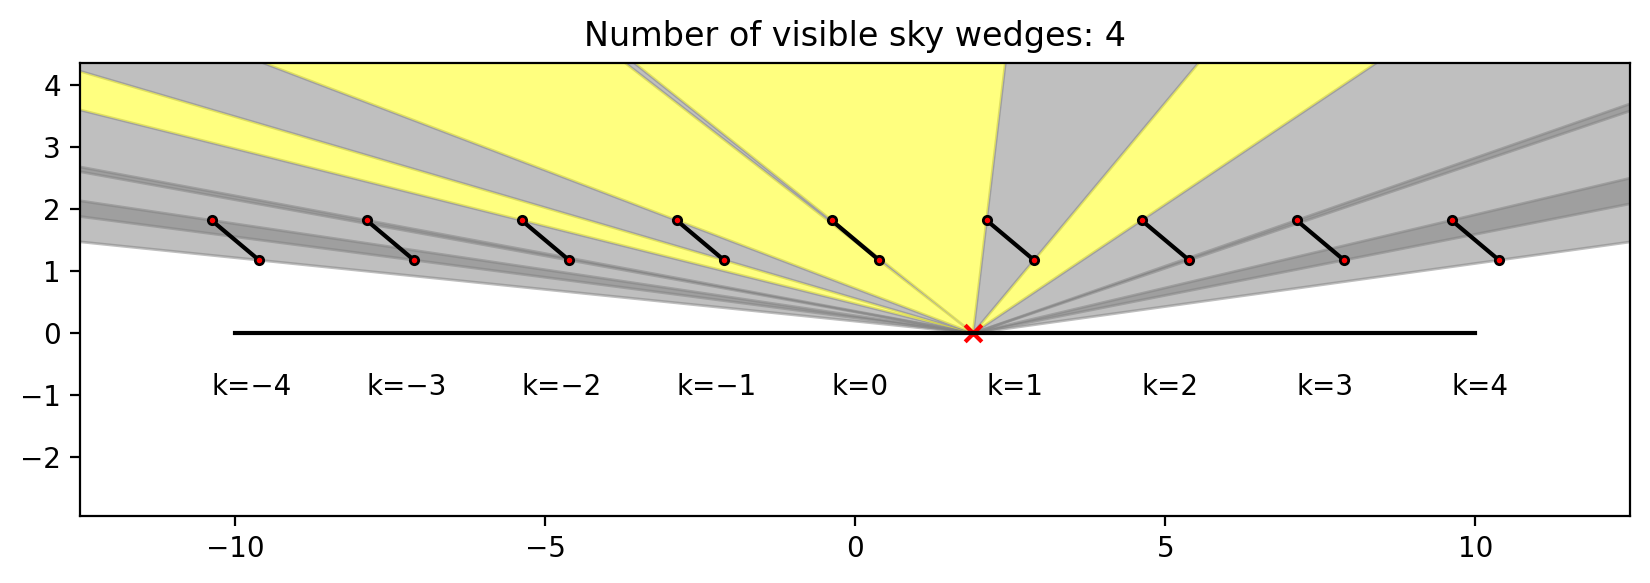

In [4]:
pitch = 2.5
collector_width = 1.0
height = 1.5  # height of middle of module above ground
rotation = 40
k_range = list(range(-4, 5))

fig, _ = plt.subplots(figsize=(10, 3), dpi=200)
_ = plot_scene(1.9, rotation, collector_width, pitch, height, fig)

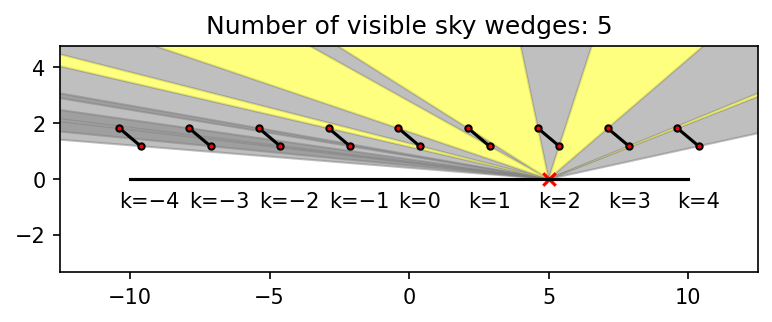

In [5]:
fig, _ = plt.subplots(figsize=(6, 2), dpi=150)

def animate(i):
    all_x = np.linspace(-pitch, 2*pitch, 200)
    this_x = all_x[i]
    _ = plot_scene(this_x, rotation, collector_width, pitch, height, fig)

ani = FuncAnimation(fig, animate, frames=200, interval=int(1000/20), repeat=True, blit=False)
HTML(ani.to_html5_video())